<a href="https://colab.research.google.com/github/khanghoang2351-design/Vohoangkhang/blob/main/final_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ========== FULL PIPELINE (Colab-ready) ==========
# Dán vào 1 cell Colab và chạy từng phần theo chú thích

# ---- 0) Mount Google Drive (chạy 1 lần) ----
from google.colab import drive
drive.mount('/content/drive')

# ---- 1) Imports & config ----
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Thay đường dẫn nếu cần:
BASE_DRIVE = "/content/drive/MyDrive"
TRAIN_DIR = os.path.join(BASE_DRIVE, "dataset_split/train")
VAL_DIR   = os.path.join(BASE_DRIVE, "dataset_split/val")
TEST_DIR  = os.path.join(BASE_DRIVE, "dataset_split/test")

# Input image size and training params
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ---- 2) Data generators (augmentation on train only) ----
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.7,1.3],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

CLASS_NAMES = list(train_gen.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", train_gen.class_indices)
print("Num classes:", NUM_CLASSES)

Found 4866 images belonging to 11 classes.
Found 1388 images belonging to 11 classes.
Found 703 images belonging to 11 classes.
Classes: {'Canh rau': 0, 'Cá hú kho': 1, 'Cơm trắng': 2, 'Rau xào': 3, 'Sườn nướng': 4, 'Thịt kho': 5, 'Thịt kho trứng': 6, 'Trứng chiên': 7, 'canh chua có cá': 8, 'canh chua không cá': 9, 'Đậu hủ sốt cà': 10}
Num classes: 11


In [ ]:
# ---- 3) Build a robust CNN (no pretrained, but well-regularized) ----
def conv_block(x, filters, kernel=3, pool=True):
    x = layers.Conv2D(filters, (kernel,kernel), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (kernel,kernel), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    if pool:
        x = layers.MaxPooling2D(2,2)(x)
    return x

def build_model(input_shape=(128,128,3), num_classes=NUM_CLASSES):
    inp = layers.Input(shape=input_shape)
    x = conv_block(inp, 32)    # 128 -> 64
    x = conv_block(x, 64)      # 64 -> 32
    x = conv_block(x, 128)     # 32 -> 16
    x = conv_block(x, 256, pool=True)  # 16 -> 8
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.35)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inp, outputs=out)
    return model

model = build_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=NUM_CLASSES)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             

 Total params: 1,444,907 (5.51 MB)

 Trainable params: 1,441,451 (5.50 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [ ]:
# ---- 4) Callbacks ----
ckpt_path = os.path.join(BASE_DRIVE, "best_model_cnn_ann.h5")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_loss', verbose=1)
]

In [ ]:
# ---- 5) Train (chạy) ----
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4318 - loss: 1.8545 
Epoch 1: val_loss improved from inf to 4.80970, saving model to /content/drive/MyDrive/best_model_cnn_ann.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 2078s 13s/step - accuracy: 0.4324 - loss: 1.8520 - val_accuracy: 0.1693 - val_loss: 4.8097 - learning_rate: 5.0000e-04
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.5731 - loss: 1.3116
Epoch 2: val_loss did not improve from 4.80970
153/153 ━━━━━━━━━━━━━━━━━━━━ 63s 411ms/step - accuracy: 0.5733 - loss: 1.3111 - val_accuracy: 0.2104 - val_loss: 4.9233 - learning_rate: 5.0000e-04
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6644 - loss: 1.0276
Epoch 3: val_loss did not improve from 4.80970
153/153 ━━━━━━━━━━━━━━━━━━━━ 60s 395ms/step - accuracy: 0.6645 - loss: 1.0273 - val_accuracy: 0.1722 - val_loss: 5.0212 - learning_rate: 5.0000e-04
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.6909 - loss: 0.8942
Epoch 4: val_loss improved from 4.80970 to 1.24848, saving model to /content/drive/MyDrive/best_model_cnn_ann.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 62s 402ms/step - accuracy: 0.6910 - loss: 0.8941 - val_accuracy: 0.6621 - val_loss: 1.2485 - learning_rate: 5.0000e-04
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7119 - loss: 0.8730
Epoch 5: val_loss improved from 1.24848 to 0.82322, saving model to /content/drive/MyDrive/best_model_cnn_ann.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 61s 399ms/step - accuracy: 0.7119 - loss: 0.8729 - val_accuracy: 0.7197 - val_loss: 0.8232 - learning_rate: 5.0000e-04
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.7339 - loss: 0.7912
Epoch 6: val_loss improved from 0.82322 to 0.79307, saving model to /content/drive/MyDrive/best_model_cnn_ann.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 60s 393ms/step - accuracy: 0.7339 - loss: 0.7913 - val_accuracy: 0.7125 - val_loss: 0.7931 - learning_rate: 5.0000e-04
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7520 - loss: 0.7203
Epoch 7: val_loss improved from 0.79307 to 0.72347, saving model to /content/drive/MyDrive/best_model_cnn_ann.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 65s 424ms/step - accuracy: 0.7520 - loss: 0.7204 - val_accuracy: 0.7370 - val_loss: 0.7235 - learning_rate: 5.0000e-04
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.7619 - loss: 0.7090
Epoch 8: val_loss improved from 0.72347 to 0.50546, saving model to /content/drive/MyDrive/best_model_cnn_ann.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 62s 406ms/step - accuracy: 0.7619 - loss: 0.7091 - val_accuracy: 0.8004 - val_loss: 0.5055 - learning_rate: 5.0000e-04
Epoch 9/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.7652 - loss: 0.7143
Epoch 9: val_loss did not improve from 0.50546
153/153 ━━━━━━━━━━━━━━━━━━━━ 65s 426ms/step - accuracy: 0.7651 - loss: 0.7144 - val_accuracy: 0.7875 - val_loss: 0.6172 - learning_rate: 5.0000e-04
Epoch 10/20
152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7825 - loss: 0.6280
Epoch 10: val_loss did not improve from 0.50546
153/153 ━━━━━━━━━━━━━━━━━━━━ 60s 391ms/step - accuracy: 0.7825 - loss: 0.6281 - val_accuracy: 0.6484 - val_loss: 1.2187 - learning_rate: 5.0000e-04
Epoch 11/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7168 - loss: 0.8361
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: val_loss did not improve from 0.50546
153/153 ━━━━━━━━━━━━━━━━━━━━ 60s 393ms/step - accuracy: 0.7170 - loss

153/153 ━━━━━━━━━━━━━━━━━━━━ 61s 402ms/step - accuracy: 0.7856 - loss: 0.5856 - val_accuracy: 0.8170 - val_loss: 0.4800 - learning_rate: 2.5000e-04
Epoch 14/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7968 - loss: 0.5641
Epoch 14: val_loss did not improve from 0.48004
153/153 ━━━━━━━━━━━━━━━━━━━━ 60s 393ms/step - accuracy: 0.7967 - loss: 0.5644 - val_accuracy: 0.7695 - val_loss: 0.6416 - learning_rate: 2.5000e-04
Epoch 15/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7852 - loss: 0.6016
Epoch 15: val_loss improved from 0.48004 to 0.40890, saving model to /content/drive/MyDrive/best_model_cnn_ann.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 61s 398ms/step - accuracy: 0.7852 - loss: 0.6017 - val_accuracy: 0.8429 - val_loss: 0.4089 - learning_rate: 2.5000e-04
Epoch 16/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8068 - loss: 0.5645
Epoch 16: val_loss did not improve from 0.40890
153/153 ━━━━━━━━━━━━━━━━━━━━ 61s 396ms/step - accuracy: 0.8067 - loss: 0.5648 - val_accuracy: 0.8098 - val_loss: 0.5145 - learning_rate: 2.5000e-04
Epoch 17/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.7505 - loss: 0.7141
Epoch 17: val_loss did not improve from 0.40890
153/153 ━━━━━━━━━━━━━━━━━━━━ 62s 403ms/step - accuracy: 0.7506 - loss: 0.7138 - val_accuracy: 0.8026 - val_loss: 0.5102 - learning_rate: 2.5000e-04
Epoch 18/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7435 - loss: 0.7256
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 18: val_loss did not improve from 0.40890
153/153 ━━━━━━━━━━━━━━━━━━━━ 60s 391ms/step - accuracy: 0.7435 - lo

153/153 ━━━━━━━━━━━━━━━━━━━━ 60s 390ms/step - accuracy: 0.7869 - loss: 0.5804 - val_accuracy: 0.8437 - val_loss: 0.3909 - learning_rate: 1.2500e-04
Epoch 20/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8213 - loss: 0.5083
Epoch 20: val_loss did not improve from 0.39093
153/153 ━━━━━━━━━━━━━━━━━━━━ 60s 394ms/step - accuracy: 0.8212 - loss: 0.5084 - val_accuracy: 0.8321 - val_loss: 0.4274 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 19.


In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test accuracy: {test_acc*100:.2f}%   Test loss: {test_loss:.4f}")

# Lưu model cuối cùng (nên dùng checkpoint model as best)
final_model_path = os.path.join(BASE_DRIVE, "model_food_cnn_ann_final.h5")
model.save(final_model_path)
print("Saved final model to:", final_model_path)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

NameError: name 'history' is not defined

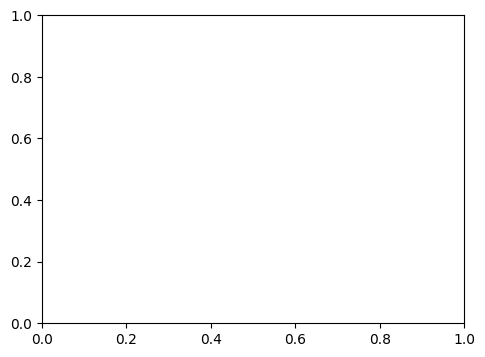

In [8]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.show()

CLASS_NAMES = list(train_gen.class_indices.keys())

# ---- 8) Fixed cropping function for tray ----
def crop_tray_fixed(img):
    """
    Cắt khay theo 5 vùng, lấy vùng trung tâm mỗi món ăn.
    Đảm bảo không bỏ qua 'bot_mid' và các box cắt đúng trọng tâm món ăn.
    """
    h, w = img.shape[:2]
    crops = {}

    # Xác định trung tâm khay (chia bố cục hợp lý)
    # Các toạ độ này giữ nguyên tỷ lệ gốc nhưng mỗi vùng sẽ lấy phần giữa thay vì cả vùng
    def center_crop(x1, y1, x2, y2, ratio=0.7):
        """Cắt vùng giữa trung tâm của vùng (x1,y1,x2,y2)."""
        cx = (x1 + x2) // 2
        cy = (y1 + y2) // 2
        new_w = int((x2 - x1) * ratio)
        new_h = int((y2 - y1) * ratio)
        nx1 = max(cx - new_w // 2, 0)
        ny1 = max(cy - new_h // 2, 0)
        nx2 = min(cx + new_w // 2, w)
        ny2 = min(cy + new_h // 2, h)
        return img[ny1:ny2, nx1:nx2].copy()

    # Vị trí gốc chia khay (giống ban đầu)
    v = {
        "top_left":  (0, 0, int(w*0.45), int(h*0.55)),
        "top_right": (int(w*0.55), 0, w, int(h*0.55)),
        "bot_left":  (0, int(h*0.55), int(w*0.33), h),
        "bot_mid":   (int(w*0.33), int(h*0.55), int(w*0.66), h),
        "bot_right": (int(w*0.66), int(h*0.55), w, h)
    }

    # Cắt vùng trung tâm mỗi phần
    for k, (x1, y1, x2, y2) in v.items():
        crops[k] = center_crop(x1, y1, x2, y2, ratio=0.7)  # 0.7 nghĩa là lấy 70% vùng giữa

    return crops


# ---- 9) Load best model + price table ----
ckpt_path = os.path.join(BASE_DRIVE, "model_food_cnn_ann_final.h5")  # hoặc đường dẫn bạn lưu
best = tf.keras.models.load_model(ckpt_path) if os.path.exists(ckpt_path) else model

menu_prices = {
    "Cơm trắng": 10000,
    "Đậu hủ sốt cà": 25000,
    "Cá hú kho": 30000,
    "Thịt kho trứng": 30000,
    "Thịt kho": 25000,
    "Canh chua có cá": 25000,
    "Canh chua không cá": 10000,
    "Sườn nướng": 30000,
    "Canh rau": 7000,
    "Rau xào": 10000,
    "Trứng chiên": 25000
}
print("Model classes:", CLASS_NAMES)

# ---- 10) Chuẩn hoá key và kiểm tra ô trống ----
import unicodedata

def normalize_text(s: str) -> str:
    s = s.strip().lower()
    s = unicodedata.normalize('NFD', s)
    s = ''.join(ch for ch in s if unicodedata.category(ch) != 'Mn')
    s = ''.join(c for c in s if not c.isspace())
    return s

menu_prices_norm = {normalize_text(k): v for k, v in menu_prices.items()}

def is_likely_empty(crop_bgr):
    gray = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    area = max(1, h*w)
    lap_var = float(cv2.Laplacian(gray, cv2.CV_64F).var())
    edges = cv2.Canny(gray, 50, 150)
    edge_ratio = np.count_nonzero(edges) / area
    hsv = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2HSV)
    v = hsv[:,:,2]; s = hsv[:,:,1]
    white_mask = (v>200)&(s<70)
    white_ratio = np.count_nonzero(white_mask) / area
    mean_v = np.mean(v)
    is_empty = (lap_var < 12.0 and edge_ratio < 0.007) or (mean_v > 240.0)
    return is_empty, {'lap_var':lap_var, 'edge_ratio':edge_ratio,
                      'white_ratio':white_ratio, 'mean_v':mean_v}


# ---- 11) Dự đoán 1 ô ----
def predict_crop_checked(crop_bgr, conf_thresh=0.45):
    is_empty, stats = is_likely_empty(crop_bgr)
    if is_empty:
        return "Trống", 0.0, 0, stats

    img_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    x = np.expand_dims(img_resized.astype("float32")/255.0, axis=0)
    preds = best.predict(x, verbose=0)
    idx = np.argmax(preds)
    conf = float(np.max(preds))
    label = CLASS_NAMES[idx]

    price = menu_prices_norm.get(normalize_text(label), 0)
    if conf < conf_thresh:
        return f"Không chắc: {label}", conf, 0, stats
    return label, conf, price, stats


# ---- 12) Dự đoán cả khay ----
def predict_tray_and_bill_checked(image_path_or_frame, show_debug=False):
    if isinstance(image_path_or_frame, str):
        img = cv2.imread(image_path_or_frame)
    else:
        img = image_path_or_frame.copy()

    crops = crop_tray_fixed(img)
    total = 0
    results = []

    print("=== KẾT QUẢ NHẬN DIỆN ===")
    for pos, crop in crops.items():
        label, conf, price, stats = predict_crop_checked(crop)
        if price > 0:
            total += price
        results.append((pos, label, conf, price))
        print(f"{pos:10s} -> {label:25s} {conf*100:5.1f}%   Giá: {price:,}đ")

    print("----------------------------")
    print(f"TỔNG TIỀN: {total:,}đ")

    if show_debug:
        vis = img.copy()
        h, w = vis.shape[:2]
        boxes = {
            "top_left":  (0, 0, int(w*0.45), int(h*0.55)),
            "top_right": (int(w*0.55), 0, w, int(h*0.55)),
            "bot_left":  (0, int(h*0.55), int(w*0.33), h),
            "bot_mid":   (int(w*0.33), int(h*0.55), int(w*0.66), h),
            "bot_right": (int(w*0.66), int(h*0.55), w, h)
        }
        for pos, (x1,y1,x2,y2) in boxes.items():
            cv2.rectangle(vis, (x1,y1), (x2,y2), (0,255,0), 3)
        y0 = 30
        for pos,label,conf,price in results:
            cv2.putText(vis, f"{pos}:{label} {conf*100:.0f}%", (10,y0),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
            y0 += 24
        from google.colab.patches import cv2_imshow
        cv2_imshow(vis)
    return results, total



In [ ]:

# ---- 13) Thử nghiệm mô hình ----
sample_path = os.path.join(BASE_DRIVE, "/content/a1.jpg")
if os.path.exists(sample_path):
    predict_tray_and_bill_checked(sample_path, show_debug=True)
else:
    print("⚠️ Không tìm thấy ảnh mẫu tại:", sample_path)

NameError: name 'predict_tray_and_bill_checked' is not defined

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
os.path.exists('/content/drive/MyDrive/best_model_cnn_ann.h5')


True

In [3]:
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/best_model_cnn_ann.h5"
model = load_model(model_path)
print("✅ Đã load thành công mô hình!")


✅ Đã load thành công mô hình!


✅ Đã load mô hình: /content/drive/MyDrive/best_model_cnn_ann.h5
Found 4866 images belonging to 11 classes.
🧩 Classes: ['Canh rau', 'Cá hú kho', 'Cơm trắng', 'Rau xào', 'Sườn nướng', 'Thịt kho', 'Thịt kho trứng', 'Trứng chiên', 'canh chua có cá', 'canh chua không cá', 'Đậu hủ sốt cà']
=== KẾT QUẢ NHẬN DIỆN ===
top_left   -> Em không nhìn rõ đại ca ơi chắc là : canh chua không cá  30.3%   Giá: 0đ
top_right  -> Cơm trắng               87.8%   Giá: 10,000đ
bot_left   -> Thịt kho trứng          90.0%   Giá: 30,000đ
bot_mid    -> Em không nhìn rõ đại ca ơi chắc là : Thịt kho trứng  23.7%   Giá: 0đ
bot_right  -> Sườn nướng           62.9%   Giá: 30,000đ
----------------------------
TỔNG TIỀN: 70,000đ


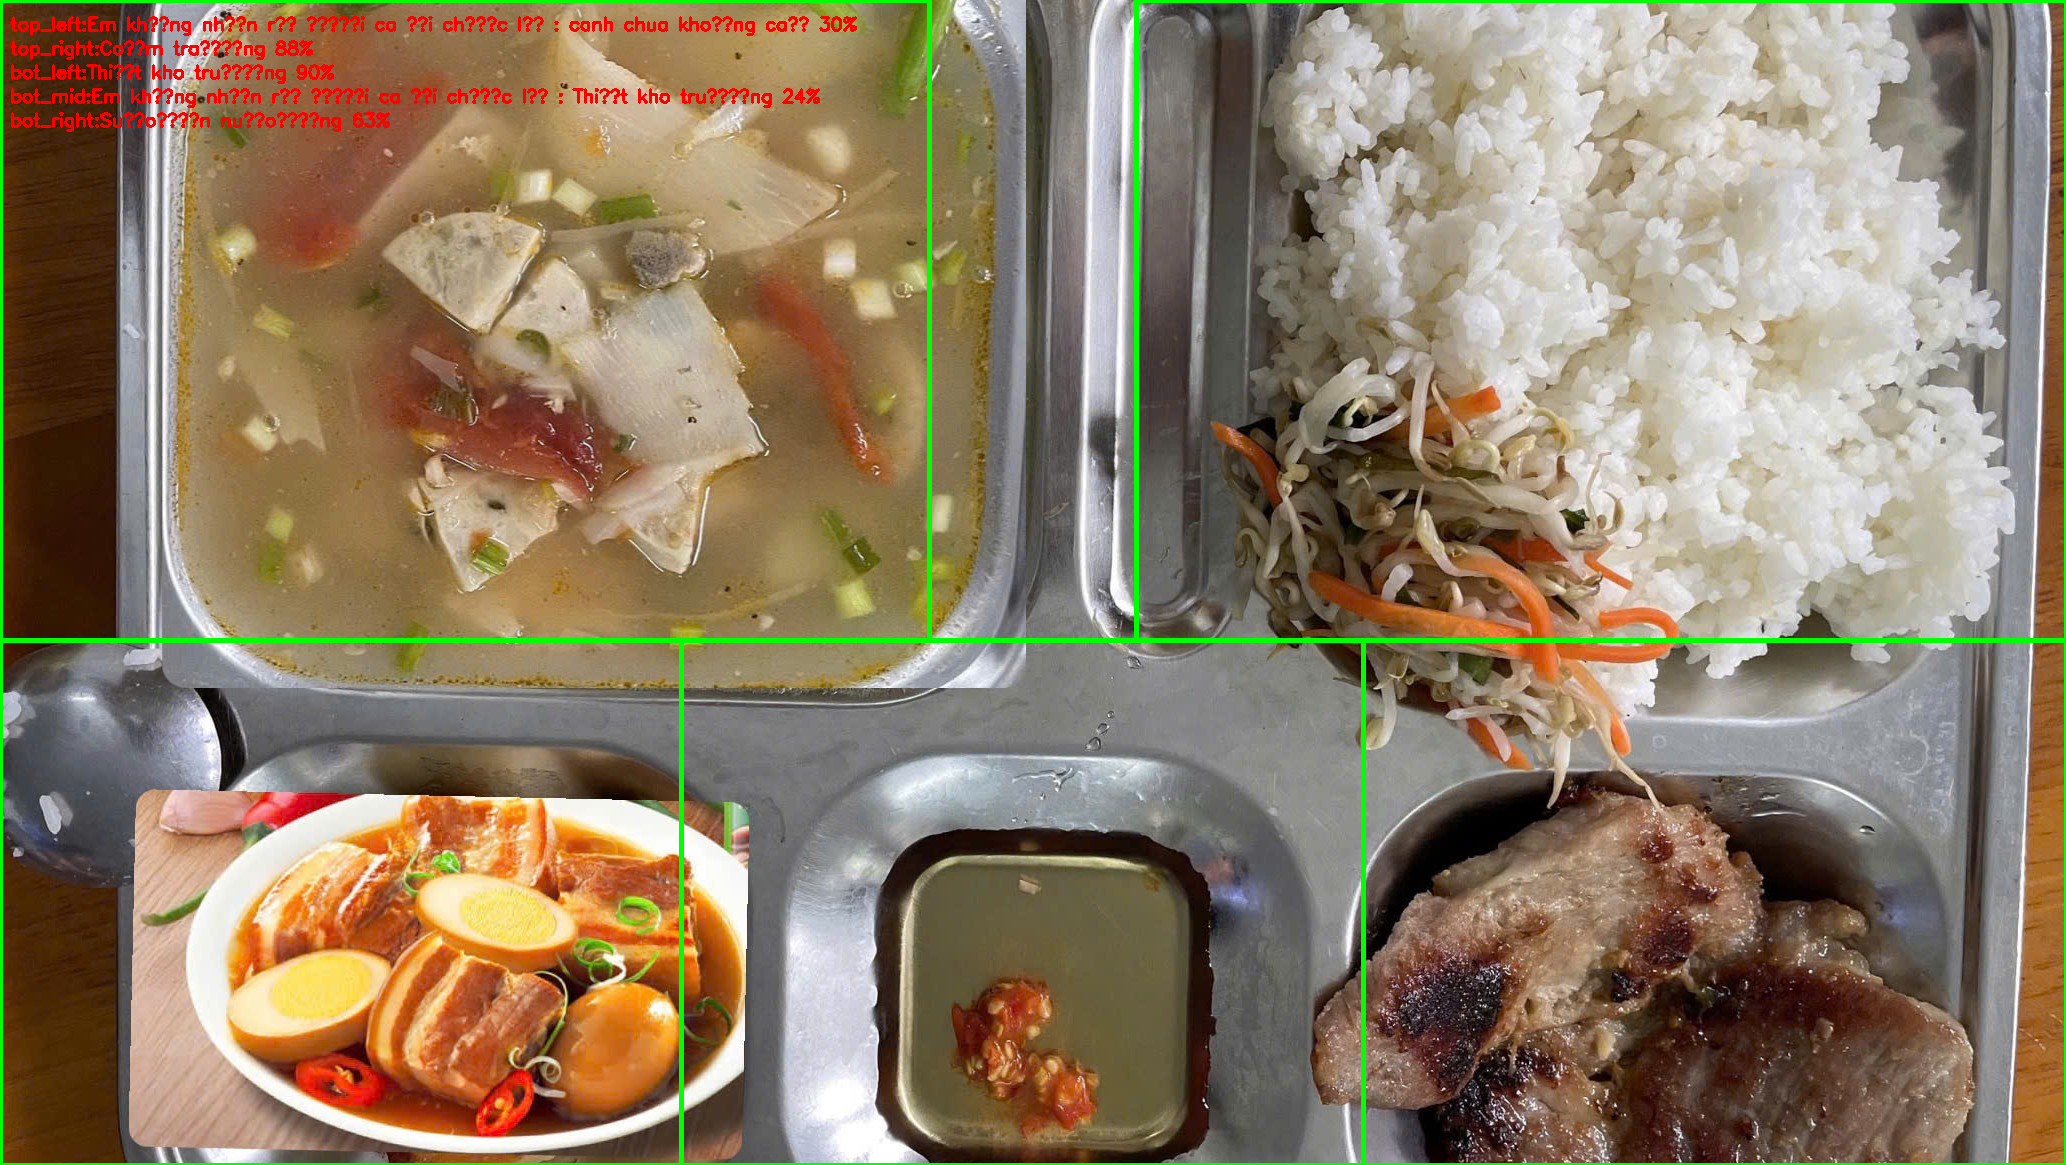

In [6]:
# ===============================================
# 🥢 NHẬN DIỆN MÓN ĂN + TÍNH TIỀN CNN/ANN THUẦN
# ===============================================

import os, cv2, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import unicodedata

# --- 1) Cấu hình ---
BASE_DRIVE = "/content/drive/MyDrive"
IMG_SIZE = (128, 128)   # giống khi bạn train
ckpt_path = os.path.join(BASE_DRIVE, "best_model_cnn_ann.h5")

# --- 2) Load model ---
model = tf.keras.models.load_model(ckpt_path)
print("✅ Đã load mô hình:", ckpt_path)

# --- 3) Class names ---
train_dir = os.path.join(BASE_DRIVE, "dataset_split/train")  # nếu bạn có dataset train
if os.path.exists(train_dir):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    temp_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir, target_size=IMG_SIZE, batch_size=1)
    CLASS_NAMES = list(temp_gen.class_indices.keys())
    print("🧩 Classes:", CLASS_NAMES)
else:
    CLASS_NAMES = ["Comtrang", "Dauhu", "Cakho", "Thitkho", "Canhchua",
                   "Suonnuong", "Canhrau", "Rauxao", "Trungchien", "Trong"]

# --- 4) Bảng giá ---
menu_prices = {
    "Cơm trắng": 10000,
    "Đậu hủ sốt cà": 25000,
    "Cá hú kho": 30000,
    "Thịt kho trứng": 30000,
    "Thịt kho": 25000,
    "Canh chua có cá": 25000,
    "Canh chua không cá": 10000,
    "Sườn nướng": 30000,
    "Canh rau": 7000,
    "Rau xào": 10000,
    "Trứng chiên": 25000
}

def normalize_text(s: str) -> str:
    s = s.strip().lower()
    s = unicodedata.normalize('NFD', s)
    s = ''.join(ch for ch in s if unicodedata.category(ch) != 'Mn')
    s = ''.join(c for c in s if not c.isspace())
    return s

menu_prices_norm = {normalize_text(k): v for k, v in menu_prices.items()}

# --- 5) Hàm cắt khay cố định ---
def crop_tray_fixed(img):
    h, w = img.shape[:2]
    crops = {}
    def center_crop(x1, y1, x2, y2, ratio=0.7):
        cx = (x1 + x2) // 2
        cy = (y1 + y2) // 2
        new_w = int((x2 - x1) * ratio)
        new_h = int((y2 - y1) * ratio)
        nx1 = max(cx - new_w // 2, 0)
        ny1 = max(cy - new_h // 2, 0)
        nx2 = min(cx + new_w // 2, w)
        ny2 = min(cy + new_h // 2, h)
        return img[ny1:ny2, nx1:nx2].copy()

    v = {
        "top_left":  (0, 0, int(w*0.45), int(h*0.55)),
        "top_right": (int(w*0.55), 0, w, int(h*0.55)),
        "bot_left":  (0, int(h*0.55), int(w*0.33), h),
        "bot_mid":   (int(w*0.33), int(h*0.55), int(w*0.66), h),
        "bot_right": (int(w*0.66), int(h*0.55), w, h)
    }
    for k, (x1, y1, x2, y2) in v.items():
        crops[k] = center_crop(x1, y1, x2, y2, ratio=0.7)
    return crops

# --- 6) Kiểm tra khay trống ---
def is_likely_empty(crop_bgr):
    gray = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    area = max(1, h*w)
    lap_var = float(cv2.Laplacian(gray, cv2.CV_64F).var())
    edges = cv2.Canny(gray, 50, 150)
    edge_ratio = np.count_nonzero(edges) / area
    hsv = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2HSV)
    v = hsv[:,:,2]; s = hsv[:,:,1]
    white_mask = (v>200)&(s<70)
    white_ratio = np.count_nonzero(white_mask) / area
    mean_v = np.mean(v)
    is_empty = (lap_var < 12.0 and edge_ratio < 0.007) or (mean_v > 240.0)
    return is_empty, {'lap_var':lap_var, 'edge_ratio':edge_ratio,
                      'white_ratio':white_ratio, 'mean_v':mean_v}

# --- 7) Dự đoán 1 vùng ---
def predict_crop_checked(crop_bgr, conf_thresh=0.45):
    is_empty, stats = is_likely_empty(crop_bgr)
    if is_empty:
        return "Trống", 0.0, 0, stats

    img_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    x = np.expand_dims(img_resized.astype("float32")/255.0, axis=0)
    preds = model.predict(x, verbose=0)
    idx = np.argmax(preds)
    conf = float(np.max(preds))
    label = CLASS_NAMES[idx]
    price = menu_prices_norm.get(normalize_text(label), 0)
    if conf < conf_thresh:
        return f"Em không nhìn rõ đại ca ơi chắc là : {label}", conf, 0, stats
    return label, conf, price, stats

# --- 8) Dự đoán toàn bộ khay + tính tiền ---
def predict_tray_and_bill_checked(image_path_or_frame, show_debug=True):
    if isinstance(image_path_or_frame, str):
        img = cv2.imread(image_path_or_frame)
    else:
        img = image_path_or_frame.copy()
    crops = crop_tray_fixed(img)
    total = 0
    results = []
    print("=== KẾT QUẢ NHẬN DIỆN ===")
    for pos, crop in crops.items():
        label, conf, price, stats = predict_crop_checked(crop)
        if price > 0:
            total += price
        results.append((pos, label, conf, price))
        print(f"{pos:10s} -> {label:25s} {conf*100:5.1f}%   Giá: {price:,}đ")
    print("----------------------------")
    print(f"TỔNG TIỀN: {total:,}đ")

    if show_debug:
        vis = img.copy()
        h, w = vis.shape[:2]
        boxes = {
            "top_left":  (0, 0, int(w*0.45), int(h*0.55)),
            "top_right": (int(w*0.55), 0, w, int(h*0.55)),
            "bot_left":  (0, int(h*0.55), int(w*0.33), h),
            "bot_mid":   (int(w*0.33), int(h*0.55), int(w*0.66), h),
            "bot_right": (int(w*0.66), int(h*0.55), w, h)
        }
        for pos, (x1,y1,x2,y2) in boxes.items():
            cv2.rectangle(vis, (x1,y1), (x2,y2), (0,255,0), 3)
        y0 = 30
        for pos,label,conf,price in results:
            cv2.putText(vis, f"{pos}:{label} {conf*100:.0f}%", (10,y0),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
            y0 += 24
        from google.colab.patches import cv2_imshow
        cv2_imshow(vis)

    return results, total


# --- 9) Test ví dụ ---
# Ví dụ: chạy với 1 ảnh khay test
test_img = os.path.join(BASE_DRIVE, "/content/aa.jpg")  # thay ảnh của bạn
if os.path.exists(test_img):
    predict_tray_and_bill_checked(test_img)
else:
    print("⚠️ Chưa có ảnh test, hãy cập nhật đường dẫn test_img")
